In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [13]:
freqs_incap = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_incap100 = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet100_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_incap01 = pd.read_csv('../metadata/freqs/class_frequency_incap_n44548_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
freqs_yfcc15m = pd.read_csv('../metadata/freqs/class_frequency_yfcc15m_cls_dedup_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
in100_idxs = pd.read_csv('../metadata/imagenet100_idxs.txt', sep='\t', header=None, names=['idx'])['idx'].to_numpy()
freq_dict = {'IN-Caps': freqs_incap, 'IN-Caps-100': freqs_incap100, 'IN-Caps (10%)': freqs_incap01, 'YFCC-15M': freqs_yfcc15m, 'YFCC15M-Cls': freqs_yfcc15m}

In [14]:
def make_metrics(metric, freqs):
    out = {}
    accs, preds = metric['per_class_accs'].numpy(), metric['per_class_pred_cnt'].numpy()
    corr_acc, corr_pred = spearmanr(freqs, accs).statistic, spearmanr(freqs, preds).statistic,
    corr_pred_acc = spearmanr(accs, preds).statistic
    out['top1'] = accs.mean()
    out['corr_acc'], out['corr_pred'] = corr_acc, corr_pred
    out['corr_pred_acc'] = corr_pred_acc
    return out

def parse_dataset(path):
    if 'in100' in path:
        dataset = 'IN-Caps-100'
    elif 'incap01' in path:
        dataset = 'IN-Caps (10%)'
    elif 'yfcc15m_cls' in path or 'yfcc15mcls' in path:
        dataset = 'YFCC15M-Cls'
    elif 'yfcc15m' in path:
        dataset = 'YFCC-15M'
    else:
        dataset = 'IN-Caps'
    return dataset

def get_our_metrics(paths, in100=True):
    metrics = []
    for path in paths:
        if 'stats_val.jsonl' in path:
            path = path.replace('stats_val.jsonl', 'metrics/metrics_imagenet_zeroshot_val_latest.pt')
        if os.path.exists(path):
            df_dict = {}
            metric = torch.load(path, map_location='cpu')
            df_dict['Dataset'] = parse_dataset(path.split('/')[-3])
            df_dict['Model'] = 'CLIP' if 'open_clip' in path else 'SL'
            freqs = freq_dict[df_dict['Dataset']]
            freqs = freqs[in100_idxs] if in100 and df_dict['Dataset'] in ['IN-Caps', 'IN-Caps (10%)'] else freqs
            metric_dict = make_metrics(metric, freqs)
            df_dict.update(metric_dict)
            metrics.append(pd.DataFrame(df_dict, index=[0]))
        else:
            print(f'{path} does not exist')
    metrics = pd.concat(metrics)
    metrics.loc[:, 'top1'] *= 100
    metrics = metrics.reset_index(drop=True)
    return metrics

In [15]:
paths = [
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-in100-freezetext_clip_wit400m/metrics/metrics_imagenet100_zeroshot_val_latest.pt',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-incap01-freezetext_clip_wit400m/metrics/metrics_imagenet100_zeroshot_val_latest.pt',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m/metrics/metrics_imagenet100_zeroshot_val_latest.pt',
    '../exps_sup/output/rn50_in100cap_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_20240326_233616/metrics_in100/metrics_val_latest.pt',
    '../exps_sup/output/rn50_incap01_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname/metrics/metrics_val_latest.pt',
    '../exps_sup/output/rn50_incap_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_20231227_023128/metricsevalonly_in100/metrics_val_latest.pt',
]
paths_yfcc = [
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-yfcc15m_cls/metrics/metrics_imagenet_zeroshot_val_latest.pt',
    '../exps_clip/logs_pretrained/RN50-yfcc15m/metrics/metrics_imagenet_zeroshot_val_latest.pt',
    '../exps_sup/output/rn50_yfcc15mcls_supcls_bs256/metrics/metrics_val_latest.pt',
]
metrics = get_our_metrics(paths, in100=True)
metrics_yfcc = get_our_metrics(paths_yfcc, in100=False)
metrics_yfcc = pd.concat([metrics_yfcc, metrics_yfcc.iloc[-1:]], ignore_index=True)
metrics_yfcc.iloc[-1, 0] = 'YFCC-15M'

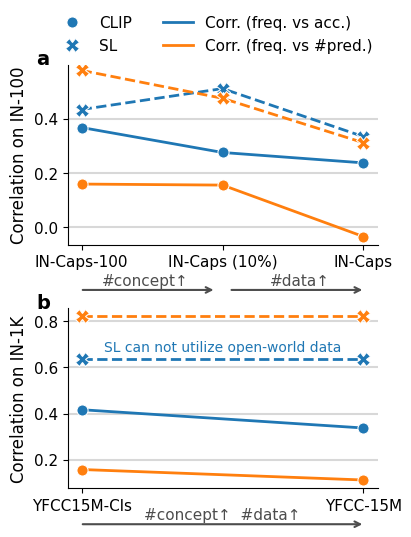

In [24]:
datasets = ['IN-Caps-100', 'IN-Caps (10%)', 'IN-Caps']
datasets_yfcc = ['YFCC15M-Cls', 'YFCC-15M']
fig, ax = plt.subplots(2, 1, figsize=(4, 5.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='y', color='gray', linestyle='-', linewidth=1.5, alpha=0.3)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='y', color='gray', linestyle='-', linewidth=1.5, alpha=0.3)

metrics = metrics.set_index('Dataset').loc[datasets].reset_index()
clip_metrics = metrics[metrics['Model'] == 'CLIP']
sl_metrics = metrics[metrics['Model'] == 'SL']
sns.lineplot(data=sl_metrics, x='Dataset', y='corr_acc', lw=2, ls='--', color='tab:blue', ax=ax[0], label='Corr. (freq. vs acc.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=sl_metrics, x='Dataset', y='corr_acc', marker='X', color='tab:blue', lw=0, markersize=10, ax=ax[0], label='SL', errorbar=None)
sns.lineplot(data=sl_metrics, x='Dataset', y='corr_pred', lw=2, ls='--', color='tab:orange', ax=ax[0], label='Corr. (freq. vs #pred.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=sl_metrics, x='Dataset', y='corr_pred', marker='X', color='tab:orange', lw=0, markersize=10, ax=ax[0], errorbar=None)
sns.lineplot(data=clip_metrics, x='Dataset', y='corr_acc', lw=2, ls='-', color='tab:blue', ax=ax[0], label='Corr. (freq. vs acc.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='Dataset', y='corr_acc', marker='o', color='tab:blue', lw=0, markersize=8, ax=ax[0], label='CLIP', errorbar=None)
sns.lineplot(data=clip_metrics, x='Dataset', y='corr_pred', lw=2, ls='-', color='tab:orange', ax=ax[0], label='Corr. (freq. vs #pred.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics, x='Dataset', y='corr_pred', marker='o', color='tab:orange', lw=0, markersize=8, ax=ax[0], errorbar=None)

metrics_yfcc = metrics_yfcc.set_index('Dataset').loc[datasets_yfcc].reset_index()
clip_metrics_yfcc = metrics_yfcc[metrics_yfcc['Model'] == 'CLIP']
sl_metrics_yfcc = metrics_yfcc[metrics_yfcc['Model'] == 'SL']
sns.lineplot(data=sl_metrics_yfcc, x='Dataset', y='corr_acc', lw=2, ls='--', color='tab:blue', ax=ax[1], label='Corr. (freq. vs acc.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=sl_metrics_yfcc, x='Dataset', y='corr_acc', marker='X', color='tab:blue', lw=0, markersize=10, ax=ax[1], label='SL', errorbar=None)
sns.lineplot(data=sl_metrics_yfcc, x='Dataset', y='corr_pred', lw=2, ls='--', color='tab:orange', ax=ax[1], label='Corr. (freq. vs #pred.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=sl_metrics_yfcc, x='Dataset', y='corr_pred', marker='X', color='tab:orange', lw=0, markersize=10, ax=ax[1], errorbar=None)
sns.lineplot(data=clip_metrics_yfcc, x='Dataset', y='corr_acc', lw=2, ls='-', color='tab:blue', ax=ax[1], label='Corr. (freq. vs acc.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics_yfcc, x='Dataset', y='corr_acc', marker='o', color='tab:blue', lw=0, markersize=8, ax=ax[1], label='CLIP', errorbar=None)
sns.lineplot(data=clip_metrics_yfcc, x='Dataset', y='corr_pred', lw=2, ls='-', color='tab:orange', ax=ax[1], label='Corr. (freq. vs #pred.)', err_kws={'zorder': 2.5, 'interpolate': True})
sns.lineplot(data=clip_metrics_yfcc, x='Dataset', y='corr_pred', marker='o', color='tab:orange', lw=0, markersize=8, ax=ax[1], errorbar=None)

ax[0].set_ylabel('Correlation on IN-100', fontsize=12)
ax[0].set_xlabel('')
ax[0].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[0].yaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].set_ylabel('Correlation on IN-1K', fontsize=12)
ax[1].set_xlabel('')
ax[1].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].yaxis.set_tick_params(labelsize=11, rotation=0)
ax[0].set_ylim(ymax=0.599)

ax[0].text(-.1, 1, 'a', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-.1, 1, 'b', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

ax[1].text(0.5, .78, 'SL can not utilize open-world data', ha='center', va='center', fontsize=10, transform=ax[1].transAxes, color='tab:blue')

ax[0].text(0.25, -.2, '#concept↑', ha='center', va='center', fontsize=11, transform=ax[0].transAxes, color='0.3')
ax[0].annotate('', xy=(.04, -.25), xytext=(.48, -.25), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='0.3'))
ax[0].text(0.75, -.2, '#data↑', ha='center', va='center', fontsize=11, transform=ax[0].transAxes, color='0.3')
ax[0].annotate('', xy=(.52, -.25), xytext=(.96, -.25), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='0.3'))
ax[1].text(0.5, -.15, '#concept↑  #data↑', ha='center', va='center', fontsize=11, transform=ax[1].transAxes, color='0.3')
ax[1].annotate('', xy=(.04, -.2), xytext=(.96, -.2), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='0.3'))

plt.subplots_adjust(hspace=.35)

ax[0].legend().remove()
ax[1].legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
handles, labels = [handles[-2], handles[1], handles[-3], handles[-1]], [labels[-2], labels[1], labels[-3], labels[-1]]
plt.legend(handles, labels, fontsize=11, loc='upper left', bbox_to_anchor=(-.08, 2.7), frameon=False, ncol=2)
plt.savefig('figs/corr_open.pdf', bbox_inches='tight', dpi=300)